# 시계열 이상치 탐지

이 노트북은 다변량 시계열을 가지고 이상치 탐색을 해결하는 몇 가지 방법을 제시한다.
  1. LSTM 모델 활용
  2. time-domain VAE 모델 활용
  3. frequency domain VAE 모델 활용
  
### 데이터
We use a synthetic dataset that simulates solar energy production time series [1].

### References
1. J. Pereira, M. Silveira, Unsupervised Anomaly Detection in Energy Time Series Data using Variational Recurrent Autoencoders with Attention, 2018

In [2]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_probability as tfp
ds = tfp.distributions

from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.preprocessing import MinMaxScaler
from scipy import signal

from sklearn.model_selection import train_test_split
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

print("Keras version " + tf.keras.__version__)
print("Tensorflow version " + tf.__version__)

#
# Helper functions
#
def minmax(x):
    # np.atleast_2d: 최소 2차원 배열, ex) [1] -> [[1]]
    return MinMaxScaler().fit_transform(np.atleast_2d(x).T).T[0]

Keras version 2.9.0
Tensorflow version 2.9.1


# 데이터 생성

패턴을 가지는 태양 에너지 시계열 데이터를 생성한다. 5가지 패턴을 사용한다.
  * Normal data (daily cycle with noise)
  * Spike - output power downtick
  * Failure - temporary outage
  * Cloud - irregular output during a cloudy day
  * Snow - low output power during a snowy day
  
normal과 cloud 데이터가 섞이는 것과 같은 이상치 데이터, 보통 데이터가 섞여있는 데이터셋을 만든다.

Shape of the normal sample: (32000,)


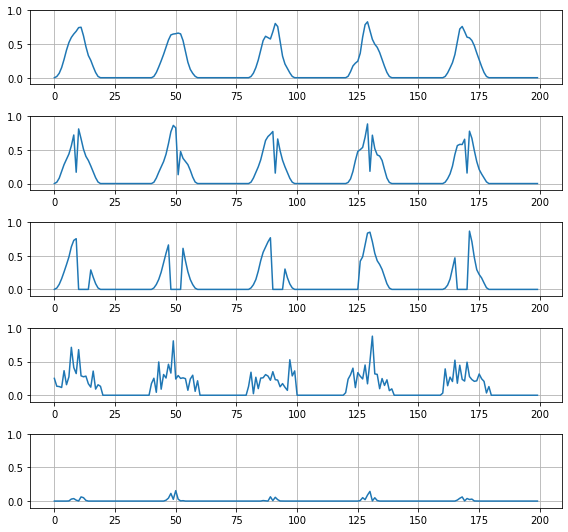

In [4]:
#
# Generate the normal sample
#
n_cycles = 800
n_halfsamples = 20
    
def generate_normal_data():
    # np.hanning -> hanning window 데이터 생성
    # np.tile -> cycle만큼 반복 데이터 생성
    normal_data = np.tile(np.hstack([np.hanning(n_halfsamples), np.zeros(n_halfsamples)]), n_cycles)

    ar1 = np.array([1, -0.9, 0.8])
    ma1 = np.array([1, 1, 1])
    ar = ArmaProcess(ar1, ma1).generate_sample(nsample=len(normal_data))
    normal_data *= np.abs(1 + 0.03 * ar) # noise 추가
    normal_data = minmax(normal_data) # scaling
    
    return normal_data

normal_data = generate_normal_data() # (32000, )

#
# Generate anomalous samples
#
spike_data = generate_normal_data()
for i in range(n_cycles):
    offset = i*2*n_halfsamples + 5 + np.random.randint(n_halfsamples-10-3)
    spike_data[offset:offset+3] *= 1 - 0.8*np.hanning(3)
    
failure_data = generate_normal_data()
for i in range(n_cycles):
    offset = i*2*n_halfsamples + np.random.randint(n_halfsamples-5)
    failure_data[offset:offset+5] *= 0
    
cloud_data = generate_normal_data()
for i in range(n_cycles):
    offset = i*2*n_halfsamples
    cloud_data[offset:offset+n_halfsamples] += np.abs(np.random.normal(0, 1, n_halfsamples))
cloud_data = minmax(cloud_data)

snow_data = np.tile(np.hstack([
    np.zeros(int(n_halfsamples/2)-5), 
    np.hanning(10), 
    np.zeros(int(n_halfsamples/2)-5), 
    np.zeros(n_halfsamples)]), n_cycles)
for i in range(n_cycles):
    offset = i*2*n_halfsamples
    snow_data[offset:offset+n_halfsamples] *= np.abs(np.random.normal(0, 0.2, n_halfsamples))
snow_data = minmax(snow_data)/4


n_plots = 5
fig, ax = plt.subplots(n_plots, 1, figsize=(8, n_plots*1.5))
ax[0].plot(normal_data[:n_halfsamples*10])
ax[1].plot(spike_data[:n_halfsamples*10])
ax[2].plot(failure_data[:n_halfsamples*10])
ax[3].plot(cloud_data[:n_halfsamples*10])
ax[4].plot(snow_data[:n_halfsamples*10])
for i in range(n_plots):
    ax[i].grid(True)
    ax[i].set_ylim(-0.1, 1)
plt.tight_layout()
print(f'Shape of the normal sample: {normal_data.shape}')

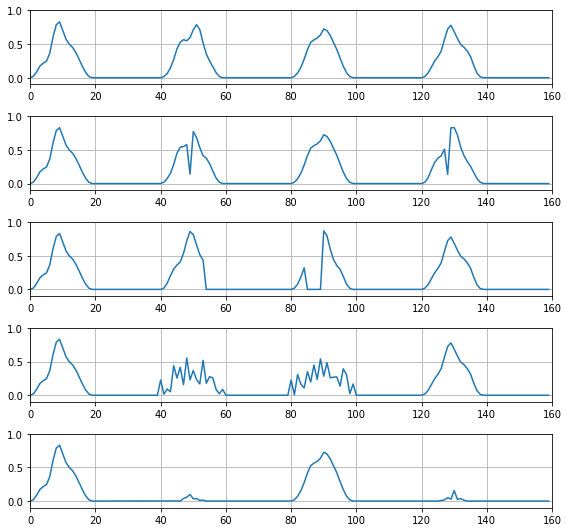

In [19]:
#
# Create mixed sets for the illustration purposes
#
n = n_halfsamples * 2
def make_example(nd, ad, mask):
    example = []
    s = (nd, ad)
    idx = n*np.array([1, 2, 3, 11, 5, 6]) # 40 * 6 = 총 240개 데이터
    
    # mask에 해당하는 부분에 anomaly data를 삽입해준다
    sample = [s[mask[i]][idx[i] : idx[i]+n] for i in range(6)]
    
    return np.hstack(sample)

normal_example = make_example(normal_data, normal_data, [0,0,0,0,0,0]) # (240, )
spike_example = make_example(normal_data, spike_data, [0,0,0,1,0,1])
failure_example = make_example(normal_data, failure_data, [0,0,0,1,1,0])
cloud_example = make_example(normal_data, cloud_data, [0,0,0,1,1,0])
snow_example = make_example(normal_data, snow_data, [0,0,0,1,0,1])

n_plots = 5
n_window = 80
fig, ax = plt.subplots(n_plots, 1, figsize=(8, n_plots*1.5))
ax[0].plot(normal_example[n_window:])
ax[1].plot(spike_example[n_window:])
ax[2].plot(failure_example[n_window:])
ax[3].plot(cloud_example[n_window:])
ax[4].plot(snow_example[n_window:])

for i in range(n_plots):
    ax[i].grid(True)
    ax[i].set_ylim(-0.1, 1)
    ax[i].set_xlim(0, 160)
plt.tight_layout()

# plt.savefig('data-examples.pdf')

# Solution 1: LSTM Forecasting Model

In this section, we develop a basic LSTM model and evaluate anomaly scores based on the difference between the forecast and actual observations. 

In [23]:
#
# dataset parameters
#
n_window = 80             # input window
forecast_steps_ahead = 5  # forecasting horizon, label offset
train_ratio = 0.8

def samples_supervised(s, n_window, forecast_steps_ahead): 
    x, y = [], []
    for i in range(n_window, len(s) - forecast_steps_ahead + 1):
        t_start = i - n_window
        t_end = i
        
        x_t = s[t_start:t_end]        
        y_t = s[t_end + forecast_steps_ahead - 1]
            
        x.append(x_t)
        y.append(y_t)
    
    return np.stack(x), np.array(y)

def train_test_split(x, y, train_ratio):
    t = int(len(x)*train_ratio)
    return x[0:t, :], y[0:t], x[t:, :], y[t:]

x, y = samples_supervised(normal_data, n_window, forecast_steps_ahead)
x_train, y_train, x_test, y_test = train_test_split(x, y, train_ratio)

#
# model parameters
#
hidden_units = 4          # LSTM state dimensionality

print(f'Train tensor shape {x_train.shape}')
print(f'Test tensor shape {x_test.shape}')

n_samples = x_train.shape[0]

input_model = layers.Input(shape=(n_window, 1))
layer_lstm = layers.LSTM(hidden_units, return_sequences = False)(input_model)
layer_dropout = layers.Dropout(rate=0.1)(layer_lstm)
output_dense = layers.Dense(1, activation='linear')(layer_dropout)
model_lstm = models.Model(inputs=input_model, outputs=output_dense)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model_lstm.compile(loss='mean_squared_error',  optimizer='adam')
model_lstm.summary()
model_lstm.fit(x_train, 
               y_train, 
               epochs=5, # 10 -> 5
               batch_size=4, 
               validation_data=(x_test, y_test), 
               use_multiprocessing=True, 
               verbose=1)
score = model_lstm.evaluate(x_test, y_test, verbose=0) 
print('Test MSE:', score) 

Train tensor shape (25532, 80)
Test tensor shape (6384, 80)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6383/6383 [==============================] - 57s 8ms/step - loss: 0.0094 - val_loss: 0.0027
Epoch 2/10
6383/6383 [==========

5/5 [==============================] - 0s 4ms/step


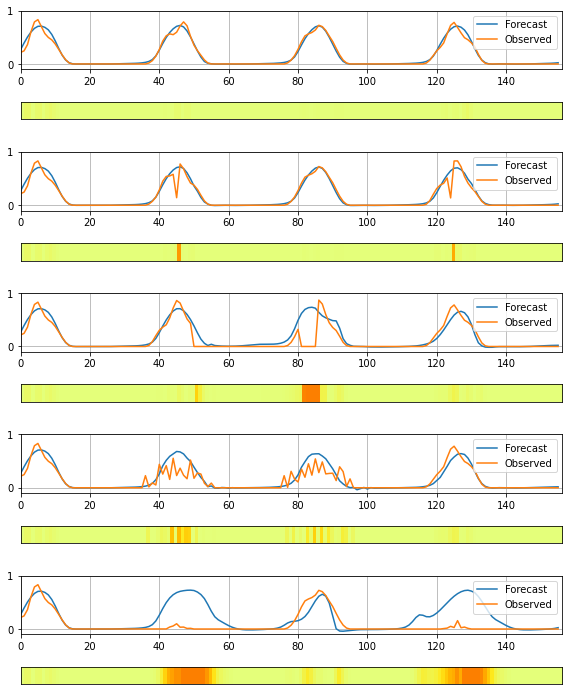

In [26]:
test_datasets = [normal_example, spike_example, failure_example, cloud_example, snow_example]

n_plots = 5
fig, ax = plt.subplots(2*n_plots, 1, figsize=(8, n_plots*2.0))
for i, d in enumerate(test_datasets):
    n_forecast = n*4 # 160
    x = samples_supervised(d, n_window, forecast_steps_ahead)[0] # (156, 80)
    
    # t시점 -> t + 5 시점 예측
    y = d[-n_forecast + forecast_steps_ahead - 1:]
    y_hat = model_lstm.predict(x).T[0]
    se = np.square(y - y_hat)

    ax[2*i].plot(y_hat.T, label=f'Forecast')
    ax[2*i].plot(y.T, label='Observed')
    ax[2*i].grid(True)
    ax[2*i].legend()
    ax[2*i].set_ylim(-0.1, 1)
    ax[2*i].set_xlim(0, len(y))
    
    ax[2*i+1].imshow(np.atleast_2d(se), aspect=5, cmap='Wistia', vmin=0, vmax=0.4)
    ax[2*i+1].set_xticks([])
    ax[2*i+1].set_yticks([])
    
plt.tight_layout()

# Solution 2: Variational Autoencoder (VAE)

In this section, we build a variational autoencoder (VAE) with convolution layers that allows to estimate anomaly scores based on the magnitude of the reconstruction error.

In [ ]:
#
# Dataset parameters
#
n_window = 80             # input window
train_ratio = 0.8

def samples_unsupervised(s, n_window): 
    x = []
    for i in range(n_window, len(s)):
        x.append(s[i - n_window : i])
    
    return np.stack(x)

def train_test_split(x, train_ratio):
    t = int(len(x) * train_ratio)
    
    return x[0:t, :], x[t:, :]

class VAE(tf.keras.Model):

    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))

        return recon_loss, latent_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
#
# Model parameters
#
n_z = 2   # embedding dimensionality
        
encoder = [
    tf.keras.layers.InputLayer( input_shape=(n_window, 1) ),
    tf.keras.layers.Conv1D(
        filters=4, kernel_size=3, activation="relu"
    ),
    tf.keras.layers.Conv1D(
        filters=8, kernel_size=3, activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=n_z*2),
]

decoder = [
    tf.keras.layers.Dense(units=20 * 8, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(20, 8)),
    tf.keras.layers.Conv1DTranspose(
        filters=8, kernel_size=3, strides=(2,), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv1DTranspose(
        filters=4, kernel_size=3, strides=(2,), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv1DTranspose(
        filters=1, kernel_size=3, strides=(1,), padding="SAME", activation="linear"
    ),
]

#
# Prepare the dataset
#
x = samples_unsupervised(normal_data, n_window)
x_train, x_test = train_test_split(x, train_ratio)

TRAIN_BUF = 60000
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF / BATCH_SIZE)
train_samples = x_train.reshape(x_train.shape[0], n_window, 1).astype("float32")
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_samples)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

#
# Model training
#
optimizer = tf.keras.optimizers.Adam(1e-3)
model_vae = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
)

n_epochs = 100
for epoch in range(n_epochs):
    print(f'Epoch {epoch}...')
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
        model_vae.train(train_x)

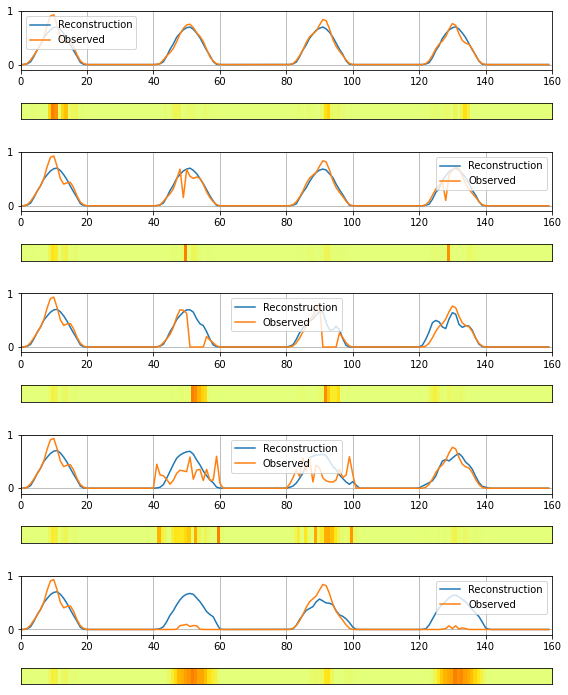

In [25]:
test_datasets = [normal_example, spike_example, failure_example, cloud_example, snow_example]

n_plots = 5
fig, ax = plt.subplots(2*n_plots, 1, figsize=(8, n_plots*2.0))
for i, d in enumerate(test_datasets):
    x = samples_unsupervised(d, n_window)
    x_hat = model_vae.reconstruct(np.atleast_3d(x)).numpy()[:, :, 0]
    
    pos = int(n_window - 1)   # 79, 중간값으로 테스트
    se = np.square(x - x_hat)[:, pos]

    ax[2*i].plot(x_hat[:, pos], label=f'Reconstruction')
    ax[2*i].plot(x[:, pos], label='Observed')
    ax[2*i].grid(True)
    ax[2*i].legend()
    ax[2*i].set_ylim(-0.1, 1)
    ax[2*i].set_xlim(0, len(x))
    
    ax[2*i+1].imshow(np.atleast_2d(se), aspect=5, cmap='Wistia')
    ax[2*i+1].set_xticks([])
    ax[2*i+1].set_yticks([])
    
plt.tight_layout()

# Solution 3: CNN Autoencoder in the Frequency Domain

In this section, we map the input series to the frequency domain using Short-time Fourier Transform (STFT), and score anomalies based on the spectrogram reconstruction using VAE.  

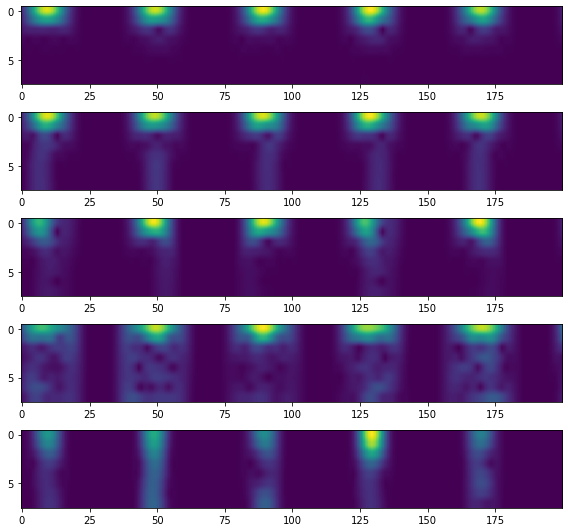

In [26]:
#
# Map the input time series to the spectral domain
#

# 푸리에타임 변환
def stft(x):
    _, _, Zxx = signal.stft(x, 1, nperseg=15, noverlap=14)
    
    return np.abs(Zxx)

normal_data_fq = stft(normal_data)
spike_data_fq = stft(spike_data)
failure_data_fq = stft(failure_data)
cloud_data_fq = stft(cloud_data)
snow_data_fq = stft(snow_data)

train_datasets_fq = [normal_data_fq, spike_data_fq, failure_data_fq, cloud_data_fq, snow_data_fq]

n_plots = 5
fig, ax = plt.subplots(n_plots, 1, figsize=(8, n_plots*1.5))
for i, d in enumerate(train_datasets_fq):
    ax[i].imshow(d[:, :n_halfsamples*10], aspect='auto', cmap='viridis')
    
plt.tight_layout()

In [ ]:
#
# Dataset parameters
#
n_window = 80             # input window
train_ratio = 0.8
n_frequencies = normal_data_fq.shape[0] 

def samples_unsupervised_2d(s, n_window):
    x = []
    for i in range(n_window, s.shape[1]):
        x.append(s[:, i - n_window : i])
    
    return np.stack(x)

def train_test_split(x, train_ratio):
    t = int(len(x)*train_ratio)
    return x[0:t, :], x[t:, :]

#
# Model parameters
#
n_z = 8   # embedding dimensionality
        
encoder = [
    tf.keras.layers.InputLayer( input_shape=(n_frequencies, n_window, 1) ),
    tf.keras.layers.Conv2D(
        filters=8, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=16, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=n_z*2),
]

decoder = [
    tf.keras.layers.Dense(units=2 * 20 * 8, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(2, 20, 8)),
    tf.keras.layers.Conv2DTranspose(
        filters=16, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=8, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="linear"
    ),
]

#
# Prepare the dataset
#
x = samples_unsupervised_2d(normal_data_fq, n_window)
x_train, x_test = train_test_split(x, train_ratio)

TRAIN_BUF = 60000
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
train_samples = x_train.reshape(x_train.shape[0], n_frequencies, n_window, 1).astype("float32")
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_samples)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

#
# Model training
#
optimizer = tf.keras.optimizers.Adam(1e-3)
model_vae_2d = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
)

n_epochs = 100
for epoch in range(n_epochs):
    print(f'Epoch {epoch}...')
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
        model_vae_2d.train(train_x)

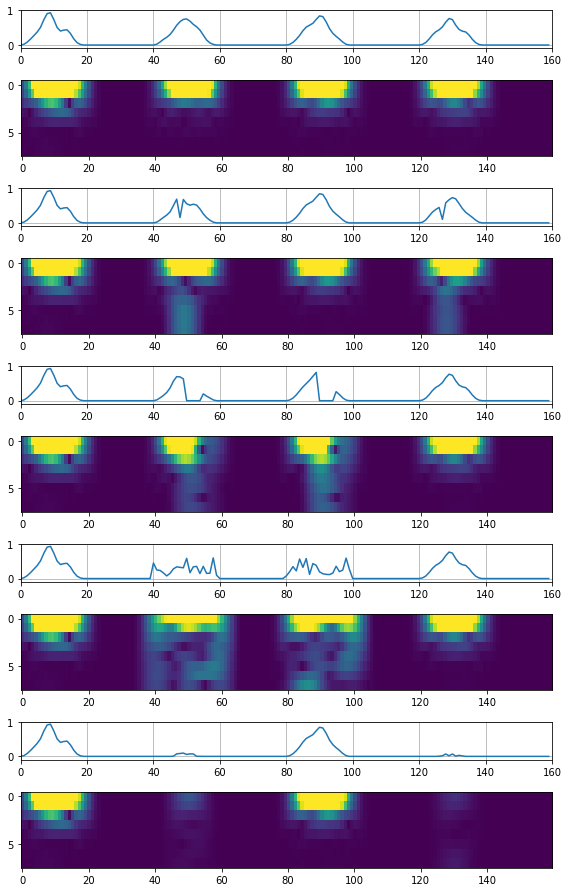

In [36]:
#
# Visualize the original spectrograms, reconstructions, and reconstruction errors
#
test_datasets = [normal_example, spike_example, failure_example, cloud_example, snow_example]

mode = 'spectrogram'   # 'spectrogram' or 'anomaly'
n_plots = 5
fig, ax = plt.subplots(2*n_plots, 1, figsize=(8, n_plots*2.5), gridspec_kw={'height_ratios': np.tile([1,2], n_plots)})
for i, d in enumerate(test_datasets):
    d_fq = stft(d)
    x = samples_unsupervised_2d(d_fq, n_window)
    x_hat = model_vae_2d.reconstruct(np.expand_dims(x, axis=3)).numpy()[:, :, :, 0]
    
    pos = int(n_window-1)   # take the middle sample from the window
    se = np.square(x - x_hat)[:, :, pos]

    ax[2*i].plot(d[n_window:])
    ax[2*i].set_ylim(-0.1, 1)
    ax[2*i].set_xlim(0, len(d)-n_window)
    ax[2*i].grid(True)
    
    if mode == 'spectrogram':
        ax[2*i+1].imshow(x[:, :, pos].T, aspect='auto', cmap='viridis', vmin=0, vmax=0.2)
    if mode == 'anomaly':
        ax[2*i+1].imshow(se.T, aspect='auto', cmap='viridis', vmin=0, vmax=0.05)
    
plt.tight_layout()